In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.utils as nn_utils
import math
from tqdm import tqdm
from tqdm import trange
#from google.colab import drive
#drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [2]:
import torch.nn as nn
import os
torch.manual_seed(42)


class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, regularization_param, regularization_exp, retrain_seed):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss


In [3]:
class Pinns:
    def __init__(self, n_int_t_, n_int_x_, n_sb_, n_tb_):
        self.n_int_t = n_int_t_
        self.n_int_x = n_int_x_
        self.n_sb = n_sb_
        self.n_tb = n_tb_
        self.tol = 0
        self.epsilon = 0.01
        self.W = None

        #Set constants
        self.nu = 0.01 / math.pi
        ones_tensor = torch.ones((n_int_t, n_int_t))
        triu_tensor = torch.triu(ones_tensor, diagonal=1)
        self.M = triu_tensor.T.to(device)


        # Extrema of the solution domain (t,x) in [0,8]x[0,1]
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [-1, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1


      # Two NNs to Approximate Fluid, Solid Temperatures
        self.approximate_solution_fluid = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                              n_hidden_layers=7,
                                              neurons=40,
                                              regularization_param=0.01,
                                              regularization_exp=2.,
                                              retrain_seed=42).to(device)
      # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0], scramble = True)
        self.soboleng_int = torch.quasirandom.SobolEngine(dimension=1, scramble = True)

      # Training Sets S_tb, S_sb, S_int as Torch Dataloader
        self.training_set_tb, self.training_set_sb, self.training_set_int, = self.assemble_datasets()

    ################################################################################################

    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    def convert_time(self, tens):
        #assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[0, 1] - self.domain_extrema[0, 0]) + self.domain_extrema[0, 0]

    def convert_space(self, tens):
        #assert (tens.shape[] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[1, 1] - self.domain_extrema[1, 0]) + self.domain_extrema[1, 0]


    def initial_conditions(self, x):
        return -torch.sin(math.pi * x)


    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_conditions(input_tb[:, 1]).reshape(-1, 1)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        t0 = self.domain_extrema[0, 0]
        t1 = self.domain_extrema[0, 1]
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]
        
        inpt = torch.linspace(t0 + self.epsilon, t1 - self.epsilon, self.n_int_t)
        inpx = torch.linspace(x0 + self.epsilon, xL - self.epsilon, self.n_int_x)
        tt, xx = torch.meshgrid(inpt, inpx)
        
        input_int = torch.cat((tt.flatten().unsqueeze(1), xx.flatten().unsqueeze(1)), dim=1)
        output_int = torch.zeros((input_int.shape[0], 1))
        
        return input_int, output_int


    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_sb, output_sb = self.add_spatial_boundary_points()  # S_sb
        input_int, output_int = self.add_interior_points()  # S_int
        
        input_tb, output_tb = input_tb.to(device), output_tb.to(device)
        input_sb, output_sb = input_sb.to(device), output_sb.to(device)
        input_int, output_int = input_int.to(device), output_int.to(device)

        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2 * self.space_dimensions * self.n_sb, shuffle=False) #2 * self.space_dimensions * self.n_sb
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int_t * self.n_int_x, shuffle=False)

        return training_set_tb, training_set_sb, training_set_int


################################################################################################

    #   Compute Temporal Boundary Residuals
    def compute_temporal_boundary_residual(self, input_tb, output_tb):
        assert(torch.all(input_tb[:,0] == 0))
        T_f = self.approximate_solution_fluid(input_tb).reshape(-1,)
        temp_tb_train = output_tb.reshape(-1,)

        assert(T_f.shape == temp_tb_train.shape)
        residual_tb = temp_tb_train - T_f

        return residual_tb.reshape(-1,)

    #   Compute Spatial Boundary Residuals
    def compute_spatial_boundary_residual(self, input_sb, output_sb):
        T_f = self.approximate_solution_fluid(input_sb).reshape(-1,)
        temp_sb_train = output_sb.reshape(-1,)

        assert(T_f.shape == temp_sb_train.shape)
        residual_sb = temp_sb_train - T_f

        return residual_sb.reshape(-1,)

    #   Compute Interior Residuals
    def compute_interior_residual(self, input_int):
        input_int.requires_grad = True
        T_f = self.approximate_solution_fluid(input_int).reshape(-1,)

        grad_T_f = torch.autograd.grad(T_f.sum(), input_int, create_graph=True)[0]
        grad_T_f_t = grad_T_f[:, 0]
        grad_T_f_x = grad_T_f[:, 1]
        grad_T_f_xx = torch.autograd.grad(grad_T_f_x.sum(), input_int, create_graph=True)[0][:, 1]

        assert(T_f.shape == grad_T_f_t.shape and T_f.shape == grad_T_f_x.shape and T_f.shape == grad_T_f_xx.shape )

        residual_int = grad_T_f_t + T_f*grad_T_f_x - self.nu *grad_T_f_xx

        return residual_int.reshape(self.n_int_t, self.n_int_x)


    #   Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_tb, T_train_tb, inp_train_sb, T_train_sb, inp_train_int, T_train_int, verbose=True):
      # Temporal Boundary Residuals
        r_tb = self.compute_temporal_boundary_residual(inp_train_tb, T_train_tb)

      # Spatial Boundary Residuals
        r_sb = self.compute_spatial_boundary_residual(inp_train_sb, T_train_sb)

      # Interior Residuals
        r_int = self.compute_interior_residual(inp_train_int)

        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_sb = torch.mean(abs(r_sb) ** 2)
        L_t = torch.mean(r_int**2, axis=1)

        self.W = torch.exp(- self.tol * torch.matmul(self.M, L_t)).detach().to(device)

        loss_int = torch.mean(self.W * L_t)

        loss_function = loss_tb + loss_sb

        loss = torch.log10(1 * (loss_tb + loss_sb) + loss_int) #+ self.approximate_solution_fluid.regularization())

        return loss, torch.log10(loss_function), torch.log10(loss_int)

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()
        # Loop over epochs
        pbar = trange(num_epochs)
        for epoch in pbar:
            for j, ((inp_train_tb, u_train_tb), (inp_train_sb, u_train_sb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_tb, self.training_set_sb, self.training_set_int)):
                optimizer.zero_grad()
                loss, loss_f, loss_i = self.compute_loss(inp_train_tb, u_train_tb, inp_train_sb, u_train_sb, inp_train_int, u_train_int, verbose=True)
                loss.backward()
                #nn_utils.clip_grad_norm_(self.approximate_solution_fluid.parameters(), max_norm=1.0)

                history.append(loss.item())
                optimizer.step()
            scheduler.step()
            pbar.set_description(f"Tol = {self.tol}, LR = {round(optimizer.param_groups[0]['lr'], 6)}, Loss = {round(loss.item(),4)}, Function = {round(loss_f.item(),4)}, PDE = {round(loss_i.item(),4)}")
            if epoch % 100 == 0:
                if self.W[-1] > 0.99:
                    break
        print('Final Loss: ', history[-1])

        return history





In [4]:
n_int_t = 64
n_int_x = 128
n_sb = 512
n_tb = 1024
pinn = Pinns(n_int_t, n_int_x, n_sb, n_tb)

C:\Users\matth\AppData\Roaming\Python\Python310\site-packages\torch\functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3491.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
n_epochs = 10000
optimizer_LBFGS = optim.LBFGS(list(pinn.approximate_solution_fluid.parameters()),
                              lr=float(0.5),
                              max_iter=2000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_grad = -1.0,
                              tolerance_change= -1.0)
                              #tolerance_change =1.0 * np.finfo(float).eps)

optimizer_ADAM = optim.Adam(pinn.approximate_solution_fluid.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ADAM, step_size=100, gamma=0.97)



Tol = 0.01, LR = 0.000715, Loss = -1.6852, Function = -2.061, PDE = -1.9225:  11%| | 1100/10000 [03:00<24:21,  6.09it/s


Final Loss:  -1.6852097511291504


Tol = 0.1, LR = 0.000296, Loss = -2.7366, Function = -3.3765, PDE = -2.8497:  29%|▎| 2900/10000 [07:48<19:07,  6.19it/s


Final Loss:  -2.736612319946289


Tol = 10.0, LR = 1.4e-05, Loss = -4.1355, Function = -4.7461, PDE = -4.2576: 100%|█| 10000/10000 [27:01<00:00,  6.17it/


Final Loss:  -4.1354827880859375


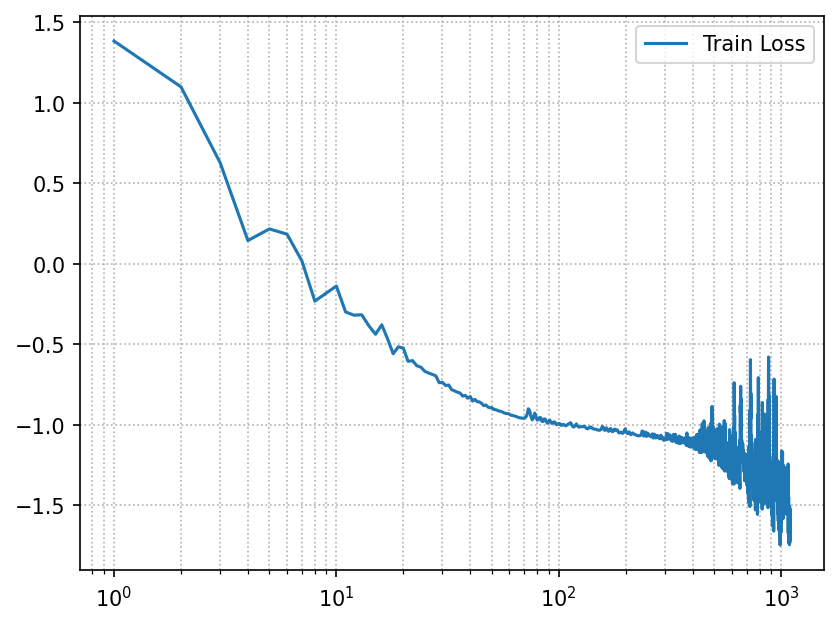

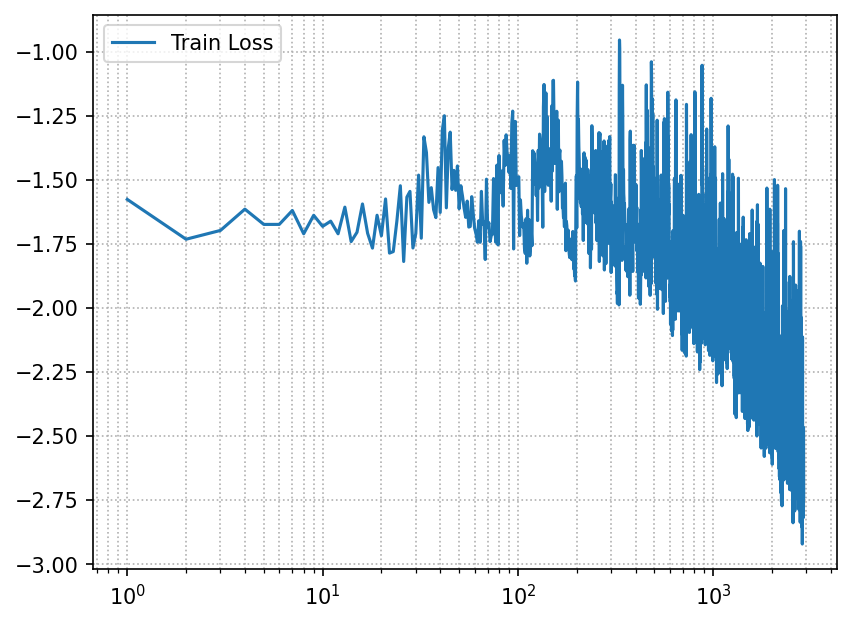

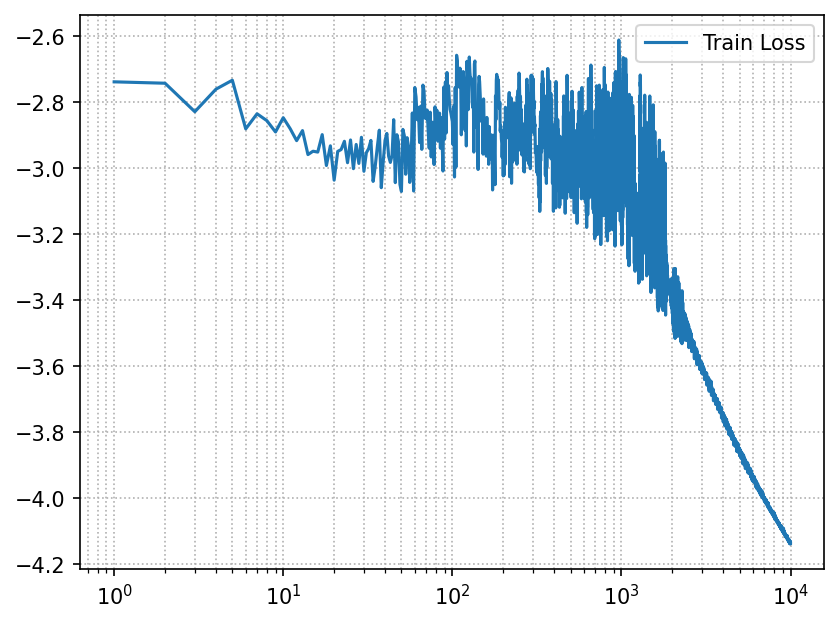

In [6]:
tol_list = [1e-2, 1e-1, 1e1]
for tol in tol_list:
  pinn.tol = tol
  hist = pinn.fit(num_epochs=n_epochs,
                  optimizer=optimizer_ADAM,
                  verbose=True)

  plt.figure(dpi=150)
  plt.grid(True, which="both", ls=":")
  plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
  plt.xscale("log")
  plt.legend()

torch.Size([256, 100]) torch.Size([256, 100])
L2 Error= tensor(0.0003, grad_fn=<MeanBackward0>)


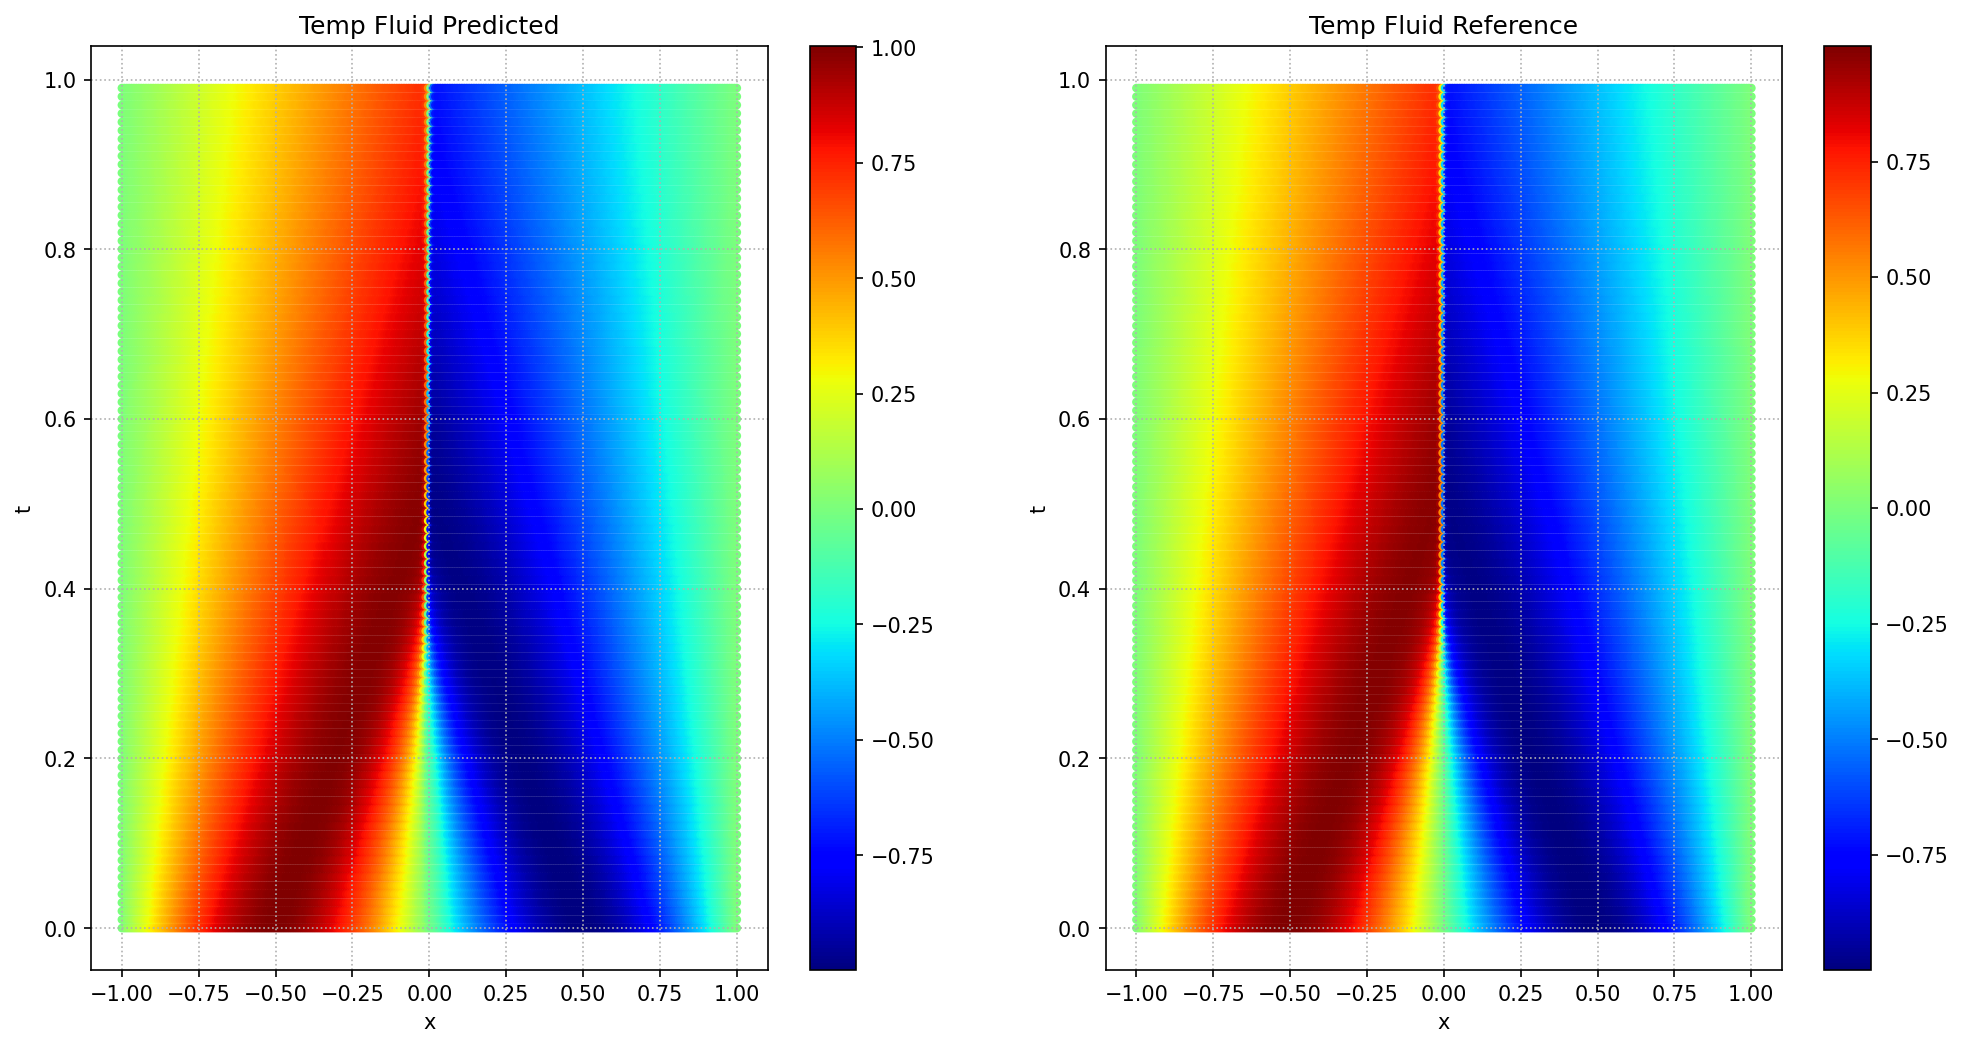

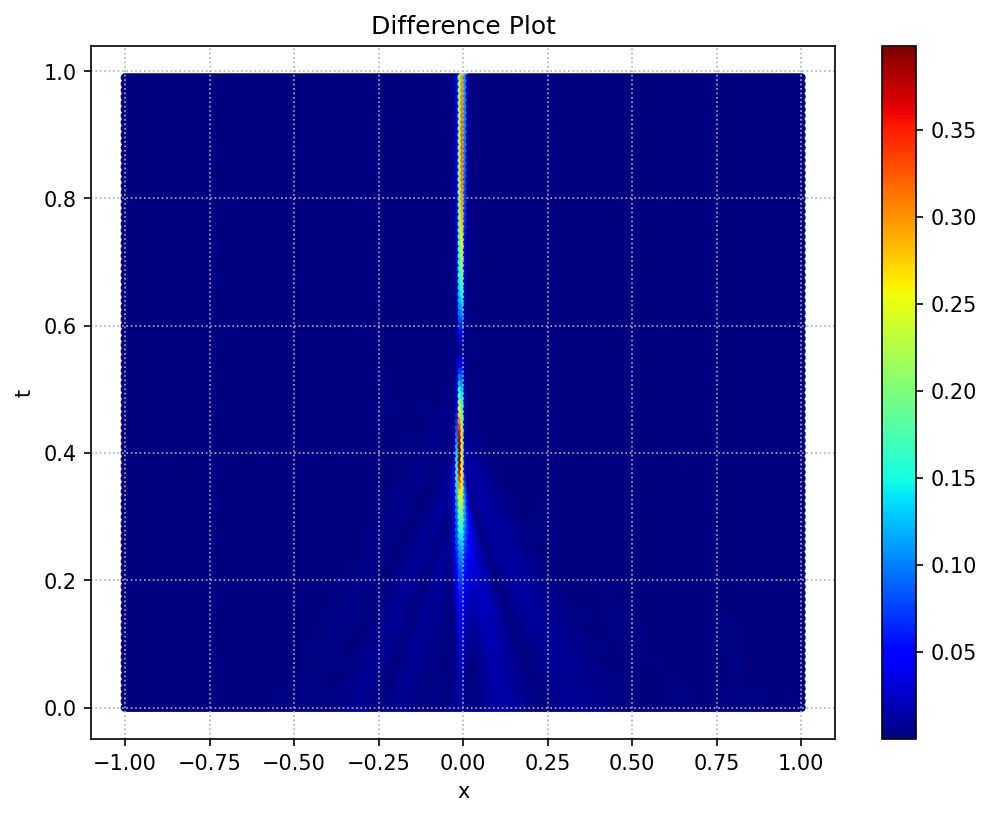

In [7]:
# Load Reference Values
data = np.load(r'C:\Users\matth\git\dlsc\Burgers_Equation\data\Burgers.npz')

t, x, exact = data["t"], data["x"], data["usol"]
tt, xx = np.meshgrid(t, x)
inputs_ref = np.vstack((np.ravel(tt), np.ravel(xx))).T
inputs_ref = torch.from_numpy(inputs_ref).to(torch.float32)

outputs_ref = torch.from_numpy(exact).to(torch.float32)


def plotting_compare(pinn):
        outputs_pinn = pinn.approximate_solution_fluid(inputs_ref.to(device)).reshape(256,100).cpu()
        print(outputs_pinn.shape, outputs_ref.shape)
        difference = torch.abs(outputs_pinn-outputs_ref)
        L2err = torch.mean(abs(outputs_pinn-outputs_ref)**2)
        print("L2 Error=",L2err)
        #vmin = outputs_ref.min()
        #vmax = outputs_ref.max()

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs_ref[:, 1].detach(), inputs_ref[:, 0].detach(), c=outputs_pinn.detach(), cmap="jet", s=10 )#vmin=vmin, vmax=vmax)
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")

        im2 = axs[1].scatter(inputs_ref[:, 1].detach(), inputs_ref[:, 0].detach(), c=outputs_ref, cmap="jet", s=10 )#vmin=vmin, vmax=vmax)
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")

        axs[0].set_title("Temp Fluid Predicted")
        axs[1].set_title("Temp Fluid Reference")

        plt.show()

        fig2, ax3 = plt.subplots(figsize=(8, 6), dpi=150)
        im3 = ax3.scatter(inputs_ref[:, 1].detach(), inputs_ref[:, 0].detach(), c=difference.detach(), cmap="jet", s=10)
        ax3.set_xlabel("x")
        ax3.set_ylabel("t")
        plt.colorbar(im3, ax=ax3)
        ax3.grid(True, which="both", ls=":")
        ax3.set_title("Difference Plot")

        plt.show()


plotting_compare(pinn)


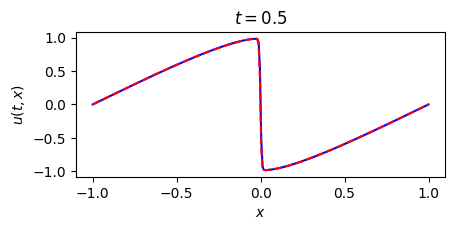

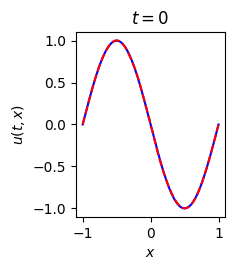

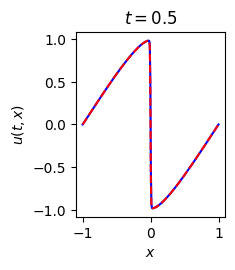

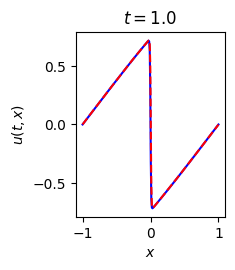

In [10]:
outputs_pinn = pinn.approximate_solution_fluid(inputs_ref.to(device)).reshape(256,100).cpu()

fig = plt.figure(figsize=(13, 4))

plt.subplot(2, 3, 2)
plt.plot(x, exact[:, 50], color='blue')
plt.plot(x, outputs_pinn[:, 50].cpu().detach().numpy(), '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 0.5$')
plt.tight_layout()
plt.show()

plt.subplot(2, 3, 2)
plt.plot(x, exact[:, 0], color='blue')
plt.plot(x, outputs_pinn[:, 0].cpu().detach().numpy(), '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 0$')
plt.tight_layout()
plt.show()


plt.subplot(2, 3, 2)
plt.plot(x, exact[:, 50], color='blue')
plt.plot(x, outputs_pinn[:, 50].cpu().detach().numpy(), '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 0.5$')
plt.tight_layout()
plt.show()

plt.subplot(2, 3, 2)
plt.plot(x, exact[:, -1], color='blue')
plt.plot(x, outputs_pinn[:, -1].cpu().detach().numpy(), '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 1.0$')
plt.tight_layout()
plt.show()



In [11]:
import pandas as pd 

outputs_pinn = pinn.approximate_solution_fluid(inputs_ref.to(device)).cpu()
submission = torch.cat((inputs_ref, outputs_pinn), dim=1)
submission = pd.DataFrame(submission.cpu().detach().numpy())

# Save the DataFrame as a text file
submission.to_csv(r"C:\Users\matth\Downloads\submission_burger.txt", sep=',', index=False, header=['t', 'x', 'u'])